In [1]:
import jax
import time
import pypomp
import unittest
import tracemalloc
import jax.numpy as jnp
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import jax.scipy.special
from functools import partial

from tqdm import tqdm
from pypomp.fit import fit
from pypomp.internal_functions import _mif_internal
from pypomp.internal_functions import _pfilter_internal

/var/folders/5v/yphhcgv17dz3dwr2sc43_pwm0000gn/T/ipykernel_940/3488694579.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Test the Linear Gaussian Model on MIF2

Model Setup

Kalman filter deals with the dynamic system:
\begin{align}
    x_t &= A x_{t-1} + w_t \\
    \text{where} \quad
    x_t &\text{ is the current state vector.} \nonumber \\
    A &\text{ is the state transition matrix.} \nonumber \\
    w_t &\sim \mathcal{N}(0, Q) \text{ is the process noise, normally distributed with mean 0 and covariance } Q. \nonumber \\
    y_t &= C x_t + v_t \\
    \text{where} \quad
    y_t &\text{ is the current observation vector.} \nonumber \\
    C &\text{ is the observation matrix.} \nonumber \\
    v_t &\sim \mathcal{N}(0, R) \text{ is the observation noise, normally distributed with mean 0 and covariance} R. \nonumber
\end{align}

In [2]:
def get_thetas(theta):
    A = theta[0:4].reshape(2, 2)
    C = theta[4:8].reshape(2, 2)
    Q = theta[8:12].reshape(2, 2)
    R = theta[12:16].reshape(2, 2)
    return A, C, Q, R

def transform_thetas(A, C, Q, R):
    return jnp.concatenate([A.flatten(), C.flatten(), Q.flatten(), R.flatten()])


fixed = False
key = jax.random.PRNGKey(111)
angle = 0.2
angle2 = angle if fixed else -0.5
A = jnp.array([[jnp.cos(angle2), -jnp.sin(angle)],
             [jnp.sin(angle), jnp.cos(angle2)]])
C = jnp.eye(2)
Q = jnp.array([[1, 1e-4],
             [1e-4, 1]]) # 100
R = jnp.array([[1, .1],
            [.1, 1]]) #/ 10
     
theta = transform_thetas(A, C, Q, R)

def generate_data(N, key):
    xs = []
    ys = []
    x = jnp.ones(2)
    for i in tqdm(range(N)):
        key, subkey = jax.random.split(key)
        x = jax.random.multivariate_normal(key=subkey, mean=A @ x, cov=Q)
        key, subkey = jax.random.split(key)
        y = jax.random.multivariate_normal(key=subkey, mean=C @ x, cov=R)
        xs.append(x)
        ys.append(y)
    xs = jnp.array(xs)
    ys = jnp.array(ys)
    return xs, ys, key

def custom_rinit(theta, J, covars=None):
    return jnp.ones((J, 2))

def custom_rproc(state, theta, key, covars=None):
    A, C, Q, R = get_thetas(theta)
    key, subkey = jax.random.split(key)
    return jax.random.multivariate_normal(key=subkey,
                                          mean=A @ state, cov=Q)
def custom_dmeas(y, preds, theta):
    A, C, Q, R = get_thetas(theta)
    return jax.scipy.stats.multivariate_normal.logpdf(y, preds, R)

rinit = custom_rinit
rproc = custom_rproc
dmeas = custom_dmeas
rprocess = jax.vmap(custom_rproc, (0, None, 0, None))
dmeasure = jax.vmap(custom_dmeas, (None, 0, None))
rprocesses = jax.vmap(custom_rproc, (0, 0, 0, None))
dmeasures = jax.vmap(custom_dmeas, (None, 0, 0))

MIF2 - Set the true parameter to be the initial value:
set J = 10, 20, 200, 1000, 2000

In [44]:
xs, ys, key = generate_data(N = 100, key = jax.random.PRNGKey(112))
theta_0 = transform_thetas(A, C, Q, R) 
sigmas = 0.002
sigmas_init = 1e-20

neg_loglik_arr_10, theta_arr_10 = _mif_internal(theta_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=10, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_20, theta_arr_20 = _mif_internal(theta_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=20, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_200, theta_arr_200 = _mif_internal(theta_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=200, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_1000, theta_arr_1000 = _mif_internal(theta_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=1000, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_2000, theta_arr_2000 = _mif_internal(theta_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=2000, thresh=-1, monitor=True, verbose=False)

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]


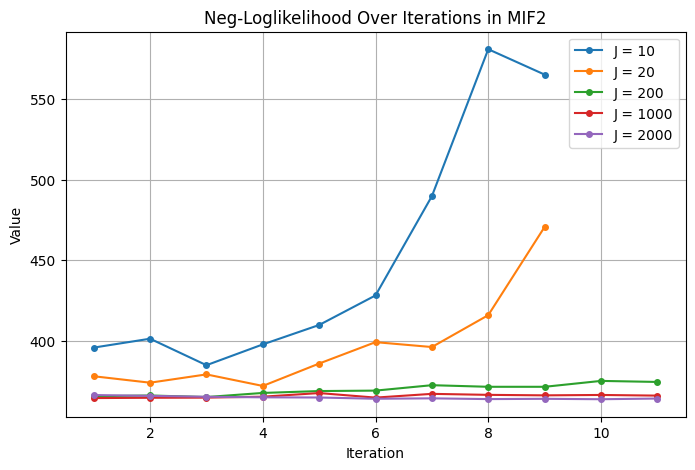

In [46]:
def remove_outliers(data):
    Q1 = jnp.percentile(data, 25)
    Q3 = jnp.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return jnp.where((data >= lower_bound) & (data <= upper_bound), data, jnp.nan)  # 用 np.nan 代替异常值

neg_loglik_arr_10_rm = remove_outliers(neg_loglik_arr_10)
neg_loglik_arr_20_rm = remove_outliers(neg_loglik_arr_20)
neg_loglik_arr_200_rm = remove_outliers(neg_loglik_arr_200)
neg_loglik_arr_1000_rm = remove_outliers(neg_loglik_arr_1000)
neg_loglik_arr_2000_rm = remove_outliers(neg_loglik_arr_2000)

iterations = np.arange(1, 12) 

plt.figure(figsize=(8, 5))
plt.plot(iterations, neg_loglik_arr_10_rm, marker='o', linestyle='-', markersize=4, label="J = 10")
plt.plot(iterations, neg_loglik_arr_20_rm, marker='o', linestyle='-', markersize=4, label="J = 20")
plt.plot(iterations, neg_loglik_arr_200_rm, marker='o', linestyle='-', markersize=4, label="J = 200")
plt.plot(iterations, neg_loglik_arr_1000, marker='o', linestyle='-', markersize=4, label="J = 1000")
plt.plot(iterations, neg_loglik_arr_2000, marker='o', linestyle='-', markersize=4, label="J = 2000")

plt.title("Neg-Loglikelihood Over Iterations in MIF2")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

plt.grid(True)
plt.show()

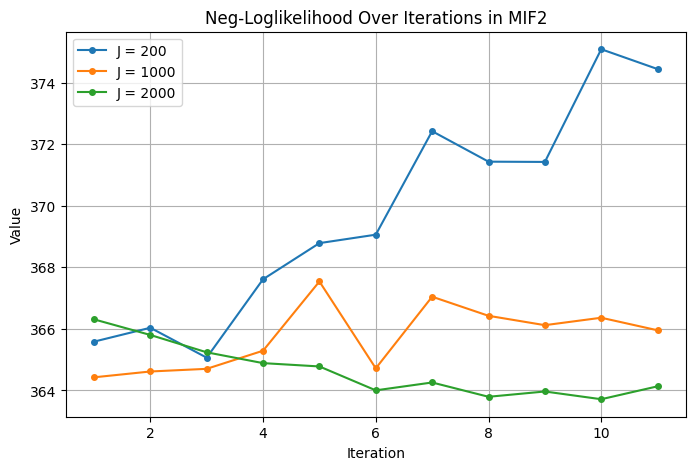

In [49]:
iterations = np.arange(1, 12) 

plt.figure(figsize=(8, 5))
#plt.plot(iterations, neg_loglik_arr_10_rm, marker='o', linestyle='-', markersize=4, label="J = 10")
#plt.plot(iterations, neg_loglik_arr_20_rm, marker='o', linestyle='-', markersize=4, label="J = 20")
plt.plot(iterations, neg_loglik_arr_200_rm, marker='o', linestyle='-', markersize=4, label="J = 200")
plt.plot(iterations, neg_loglik_arr_1000, marker='o', linestyle='-', markersize=4, label="J = 1000")
plt.plot(iterations, neg_loglik_arr_2000, marker='o', linestyle='-', markersize=4, label="J = 2000")

plt.title("Neg-Loglikelihood Over Iterations in MIF2")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

plt.grid(True)
plt.show()

When J = 200, the negative log-likelihood fluctuates significantly and shows an overall increasing trend, indicating unstable optimization when the number of particles is insufficient. When J = 1000, the negative loglikelihood value has moderate fluctuations but remains relatively controlled and stable. J = 2000 leads to the most stable log-likelihood result, with consistently lower negative log-likelihood values at each iteration. This trend suggests that a larger particle size provides more reliable optimization results and lower negative log-likelihood values. But there also exists a trade-off between computational cost and stability

MIF2 - Uniformaly Draw Parameters from (Lower, Upper): set J = 10, 20, 200, 2000

In [76]:
A_low = jnp.array([[jnp.cos(angle2), -jnp.sin(angle)],
                [jnp.sin(angle), jnp.cos(angle2)]]) * 0.5
C_low = jnp.eye(2) * 0.5
Q_low = jnp.array([[1, 1e-4],
                  [1e-4, 1]]) * 0.5
R_low = jnp.array([[1, .1],
                   [.1, 1]]) * 0.5
lows = transform_thetas(A_low, C_low, Q_low, R_low)

A_high = jnp.array([[jnp.cos(angle2), -jnp.sin(angle)],
                [jnp.sin(angle), jnp.cos(angle2)]]) * 1.5
C_high = jnp.eye(2) * 1.5
Q_high = jnp.array([[1, 1e-4],
                  [1e-4, 1]]) * 1.5
R_high= jnp.array([[1, .1],
                   [.1, 1]]) * 1.5
highs = transform_thetas(A_high, C_high, Q_high, R_high)

rands = np.random.uniform(lows, highs, size = (1, len(highs)))
rands_0 = jnp.array(rands)[0,:]


In [83]:
neg_loglik_arr_10_rands, theta_arr_10_rands = _mif_internal(rands_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=10, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_20_rands, theta_arr_20_rands = _mif_internal(rands_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=20, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_200_rands, theta_arr_200_rands = _mif_internal(rands_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=200, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_1000_rands, theta_arr_1000_rands = _mif_internal(rands_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=1000, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_2000_rands, theta_arr_2000_rands = _mif_internal(rands_0, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.002, 1e-20, None, M=10, a=0.95, J=2000, thresh=-1, monitor=True, verbose=False)

100%|██████████| 10/10 [00:02<00:00,  3.79it/s]


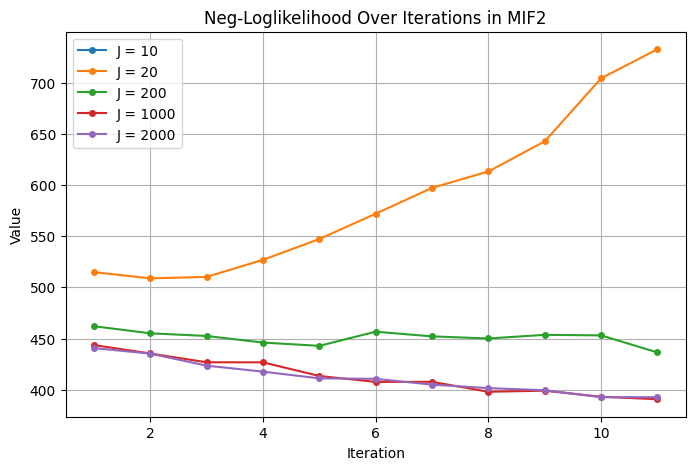

In [90]:
neg_loglik_arr_10_rands_rm = remove_outliers(neg_loglik_arr_10_rands)

iterations = np.arange(1, 12) 

plt.figure(figsize=(8, 5))
plt.plot(iterations, neg_loglik_arr_10_rands_rm, marker='o', linestyle='-', markersize=4, label="J = 10")
plt.plot(iterations, neg_loglik_arr_20_rands, marker='o', linestyle='-', markersize=4, label="J = 20")
plt.plot(iterations, neg_loglik_arr_200_rands, marker='o', linestyle='-', markersize=4, label="J = 200")
plt.plot(iterations, neg_loglik_arr_1000_rands, marker='o', linestyle='-', markersize=4, label="J = 1000")
plt.plot(iterations, neg_loglik_arr_2000_rands, marker='o', linestyle='-', markersize=4, label="J = 2000")

plt.title("Neg-Loglikelihood Over Iterations in MIF2")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

plt.grid(True)
plt.show()

Random initial points lead to a more obvious decreasing trend, but the algorithm does not fully recover the best possible likelihood values after 10 iterations, and more iterations are needed.

 MIF2 - Parameter Starting Value = True Value * 0.8 (bias) and increasing the purterbation

In [99]:
theta_bias = theta_0 * 0.8

neg_loglik_arr_10_bias, theta_arr_10_rands = _mif_internal(theta_bias, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.02, 1e-20, None, M=10, a=0.95, J=10, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_20_bias, theta_arr_20_rands = _mif_internal(theta_bias, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.02, 1e-20, None, M=10, a=0.95, J=20, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_200_bias, theta_arr_200_rands = _mif_internal(theta_bias, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.02, 1e-20, None, M=10, a=0.95, J=200, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_1000_bias, theta_arr_1000_rands = _mif_internal(theta_bias, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.02, 1e-20, None, M=10, a=0.95, J=1000, thresh=-1, monitor=True, verbose=False)
neg_loglik_arr_2000_bias, theta_arr_2000_rands = _mif_internal(theta_bias, ys, rinit, rprocess, dmeasure, rprocesses, dmeasures, 0.02, 1e-20, None, M=10, a=0.95, J=2000, thresh=-1, monitor=True, verbose=False)

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


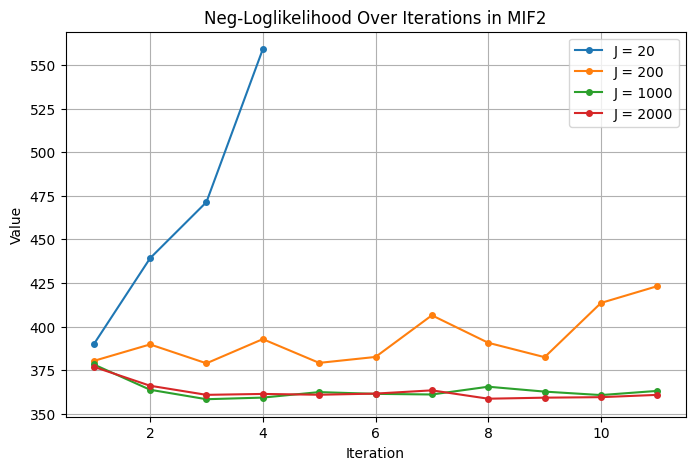

In [100]:
iterations = np.arange(1, 12) 

plt.figure(figsize=(8, 5))
#plt.plot(iterations, neg_loglik_arr_10_bias, marker='o', linestyle='-', markersize=4, label="J = 10")
plt.plot(iterations, neg_loglik_arr_20_bias, marker='o', linestyle='-', markersize=4, label="J = 20")
plt.plot(iterations, neg_loglik_arr_200_bias, marker='o', linestyle='-', markersize=4, label="J = 200")
plt.plot(iterations, neg_loglik_arr_1000_bias, marker='o', linestyle='-', markersize=4, label="J = 1000")
plt.plot(iterations, neg_loglik_arr_2000_bias, marker='o', linestyle='-', markersize=4, label="J = 2000")

plt.title("Neg-Loglikelihood Over Iterations in MIF2")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

plt.grid(True)
plt.show()

Comparison with MIF2 in R-POMP package

### Test the Dacca

In [4]:
def sigmoid(x):
    return 1/(1+jnp.exp(-x))

def logit(x):
    return jnp.log(x/(1-x))

def get_thetas_dacca(theta):
    gamma = jnp.exp(theta[0]) # recovery rate
    m = jnp.exp(theta[1]) # death probability
    rho = jnp.exp(theta[2]) # 1/rho - mean duration of short-term immunity
    epsilon = jnp.exp(theta[3]) # 1/eps - mean duration of immunity
    omega = jnp.exp(theta[4]) # mean foi
    c = sigmoid(theta[5] ) # probability exposure infects
    beta_trend = theta[6] / 100 # trend in foi
    sigma = jnp.exp(theta[7]) # stdev of foi perturbations
    tau = jnp.exp(theta[8]) # stdev of gaussian measurements
    bs = theta[9:15] # seasonality coefficients
    omegas = theta[15:]
    k = 3# 1/(jnp.exp(theta[3])**2) # 1/sqrt(k) - coefficient of variation of immune period
    delta = 0.02 # death rate
    return gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas, k, delta

def transform_thetas_dacca(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas):
    return jnp.concatenate([jnp.array([jnp.log(gamma), jnp.log(m), jnp.log(rho), jnp.log(epsilon), jnp.log(omega),
                    logit(c), beta_trend * 100, jnp.log(sigma), jnp.log(tau)]), bs, omegas])

def rinit_dacca(theta, J, covars):
    S_0, I_0, Y_0, R1_0, R2_0, R3_0 = 0.621, 0.378, 0, 0.000843, 0.000972, 1.16e-07
    pop = covars[0,2]
    S = pop*S_0
    I = pop*I_0
    Y = pop*Y_0
    R1 = pop*R1_0
    R2 = pop*R2_0
    R3 = pop*R3_0
    Mn = 0
    t = 0
    count = 0
    return jnp.tile(jnp.array([S,I,Y,Mn,R1,R2,R3,t, count]), (J,1))

def rinits_dacca(thetas, J, covars):
    return rinit_dacca(thetas[0], len(thetas), covars)

def dmeas_helper(y, deaths, v, tol, ltol):
    return jnp.logaddexp(
        jax.scipy.stats.norm.logpdf(y, loc=deaths, scale=v+tol), 
                     ltol)
def dmeas_helper_tol(y, deaths, v, tol, ltol):
    return ltol

def dmeas_dacca(y, preds, theta, keys=None):
    deaths = preds[3]; count = preds[-1]; tol = 1.0e-18
    ltol = jnp.log(tol)
    gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas, k, delta = get_thetas_dacca(theta)
    v = tau*deaths
    #return jax.scipy.stats.norm.logpdf(y, loc=deaths, scale=v)
    return jax.lax.cond(jnp.logical_or((1-jnp.isfinite(v)).astype(bool), count>0), #if Y < 0 then count violation
                         dmeas_helper_tol, 
                         dmeas_helper,
                       y, deaths, v, tol, ltol)

dmeasure_dacca = jax.vmap(dmeas_dacca, (None,0,None))
dmeasures_dacca = jax.vmap(dmeas_dacca, (None,0,0))

def rproc_dacca(state, theta, key, covar):
    S, I, Y, deaths, pts, t, count = state[0], state[1], state[2], state[3], state[4:-2], state[-2], state[-1]
    t = t.astype(int)
    trends, dpopdts, pops, seass = covar[:,0], covar[:,1], covar[:,2], covar[:,3:]
    gamma, deltaI, rho, eps, omega, clin, beta_trend, sd_beta, tau, bs, omegas, nrstage, delta = get_thetas_dacca(theta)
    dt = 1/240
    deaths = 0
    nrstage = 3
    clin = 1 # HARDCODED SEIR
    rho = 0 # HARDCODED INAPPARENT INFECTIONS
    std = np.sqrt(dt) #np.sqrt(np.sqrt(dt))
    
    neps = eps*nrstage
    rdeaths = jnp.zeros(nrstage)
    passages = jnp.zeros(nrstage+1)
    

    for i in range(20):
        trend = trends[t]; dpopdt = dpopdts[t]; pop = pops[t]; seas = seass[t]
        beta = jnp.exp(beta_trend*trend + jnp.dot(bs, seas))
        omega = jnp.exp(jnp.dot(omegas, seas))
        
        subkey, key = jax.random.split(key)
        dw = jax.random.normal(subkey)*std #rnorm uses variance sqrt(dt), not stdev
        
        effI = I/pop
        births = dpopdt + delta*pop # births
        passages = passages.at[0].set(gamma*I) #recovery
        ideaths = delta*I #natural i deaths
        disease = deltaI*I #disease death
        ydeaths = delta*Y #natural rs deaths
        wanings = rho*Y #loss of immunity
        
        for j in range(nrstage):
            rdeaths = rdeaths.at[j].set(pts[j]*delta) #natural R deaths
            passages = passages.at[j+1].set(pts[j]*neps) # passage to the next immunity class
            
        infections = (omega+(beta+sd_beta*dw/dt)*effI)*S # infection
        sdeaths = delta*S # natural S deaths
        
        S += (births - infections - sdeaths + passages[nrstage] + wanings)*dt
        I += (clin*infections - disease - ideaths - passages[0])*dt
        Y += ((1-clin)*infections - ydeaths - wanings)*dt
        for j in range(nrstage):
            pts = pts.at[j].add((passages[j] - passages[j+1] - rdeaths[j])*dt)
        deaths += disease*dt # cumulative deaths due to disease
                        
        count += jnp.any(jnp.hstack([jnp.array([S, I, Y, deaths]), pts]) < 0)
        
        S = jnp.clip(S, a_min=0); I = jnp.clip(I, a_min=0); Y = jnp.clip(Y, a_min=0)
        pts = jnp.clip(pts, a_min=0); deaths = jnp.clip(deaths, a_min=0)
        
        t += 1

    return jnp.hstack([jnp.array([S, I, Y, deaths]), pts, jnp.array([t]), jnp.array([count])])

rprocess_dacca = jax.vmap(rproc_dacca, (0, None, 0, None))
rprocesses_dacca = jax.vmap(rproc_dacca, (0, 0, 0, None))

In [5]:
dataset = pd.read_csv('./dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
dataset = pd.read_csv('./dacca/covars.csv', index_col=0).reset_index(drop=True)
dataset.index = pd.read_csv('./dacca/covart.csv', index_col=0).reset_index(drop=True).squeeze()
dataset = dataset.reindex(np.array([1891 + i*(1/240) for i in range(12037)])).interpolate()
covars = np.array(dataset.values)

gamma = 20.8
epsilon = 19.1
rho = 0
delta = 0.02
m = 0.06
c = jnp.array(1)
beta_trend = -0.00498
bs = jnp.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13 #3.13 # 0.77
tau = 0.23 
omega = jnp.exp(-4.5)
omegas = jnp.log(jnp.array([0.184, 0.0786, 0.0584, 0.00917, 0.000208, 0.0124]))

theta_dacca = transform_thetas_dacca(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

In [6]:
def get_rand_theta():
    return transform_thetas_dacca(jnp.random.uniform(10.00, 40.00),
                jnp.random.uniform(0.03, 0.60), 
                         rho, 
                jnp.random.uniform(0.20, 30.00), 
                         omega, 
                         c, 
                jnp.random.uniform(-1.00, 0.00)*0.01, 
                jnp.random.uniform(1.00, 5.00), 
                jnp.random.uniform(0.10, 0.50), 
                jnp.random.uniform(0,8,size=6)+np.array([-4,0,-4,0,0,0]), 
                jnp.random.uniform(-10,0,size=6))

def get_sds():    
    lows = transform_thetas_dacca(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             jnp.zeros(6)+jnp.array([-4,0,-4,0,0,0]), 
            -10*np.ones(6))
    highs = transform_thetas_dacca(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*jnp.ones(6)+jnp.array([-4,0,-4,0,0,0]), 
                jnp.zeros(6))
    return (highs-lows)/100

def get_rand_theta(J):
    lows = transform_thetas_dacca(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             jnp.zeros(6)+jnp.array([-4,0,-4,0,0,0]), 
            -10*np.ones(6))
    highs = transform_thetas_dacca(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*jnp.ones(6)+jnp.array([-4,0,-4,0,0,0]), 
                jnp.zeros(6))
    rands = np.array(jnp.repeat(((lows+highs)/2)[None,:], J, axis=0)).T
    rands[~np.isinf(lows)] = np.random.uniform(lows[~np.isinf(lows)], 
                       highs[~np.isinf(highs)],
                       size=(J, len(highs[~np.isinf(highs)]))).T
    return rands.T

def log_in_bbox(theta):    
    valids = jnp.array([i for i in range(len(theta)) if i not in [2,5]])
    lows = transform_thetas_dacca(10.00,0.03, rho, 0.20, omega, c, 
             -1.00*0.01, 1.00, 0.10, 
             jnp.zeros(6)+jnp.array([-4,0,-4,0,0,0]), 
            -10*jnp.ones(6))
    highs = transform_thetas_dacca(40.00,0.60, rho, 30.00, omega, c, 
                 0.00, 5.00, 0.50, 
                 8*jnp.ones(6)+jnp.array([-4,0,-4,0,0,0]), 
                jnp.zeros(6))

    return -100*jnp.log(1-(jnp.logical_or(jnp.any(lows[valids] > theta[valids]),
                                        jnp.any(theta[valids] > highs[valids])))+1e-43)

### MIF2: Uniformaly Draw Random Parameters from (Lower, Upper), sigmas = 0.02, sigmas_init = 1e-20

In [ ]:
J1 = 10
J2 = 20
J3 = 200
J4 = 1000
J5 = 2000

bbox = get_rand_theta(1).squeeze()
mif_logliks_J1_rand, mif_params_J1_rand = _mif_internal(theta=bbox, ys=ys, sigmas=0.02, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J1, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca) 
mif_logliks_J2_rand, mif_params_J2_rand = _mif_internal(theta=bbox, ys=ys, sigmas=0.02, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J2, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J3_rand, mif_params_J3_rand = _mif_internal(bbox, ys, sigmas=0.02, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J3, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J4_rand, mif_params_J4_rand = _mif_internal(bbox, ys, sigmas=0.02, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J4, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J5_rand, mif_params_J5_rand = _mif_internal(bbox, ys, sigmas=0.02, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J5, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)

100%|██████████| 10/10 [00:20<00:00,  2.02s/it]


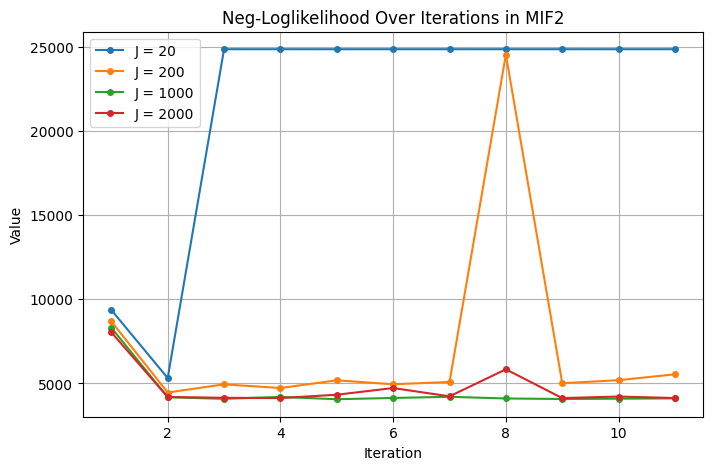

In [ ]:
iterations = np.arange(1, 12) 

plt.figure(figsize=(8, 5))
#plt.plot(iterations, neg_loglik_arr_10_bias, marker='o', linestyle='-', markersize=4, label="J = 10")#
plt.plot(iterations, mif_logliks_J2_rand, marker='o', linestyle='-', markersize=4, label="J = 20")
plt.plot(iterations, mif_logliks_J3_rand, marker='o', linestyle='-', markersize=4, label="J = 200")
plt.plot(iterations, mif_logliks_J4_rand, marker='o', linestyle='-', markersize=4, label="J = 1000")
plt.plot(iterations, mif_logliks_J5_rand, marker='o', linestyle='-', markersize=4, label="J = 2000")

plt.title("Neg-Loglikelihood Over Iterations in MIF2, sigmas = 0.02")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

plt.grid(True)
plt.show()

Unlike the previous two MIF2 results in simpler LG models (where negative log-likelihood had smoother trends), this complex dacca model exhibits more instability, particularly for small number of particles (J). Small Js could lead to extreme divergence and large spikes, indicating instability. Higher J helps to mitigate the instability.

Use true parameter, set simgas = 0.02, 0.005, 0.00005

In [10]:
bbox = get_rand_theta(1).squeeze()
mif_logliks_J2_true_1, mif_params_J2_true_1 = _mif_internal(theta_dacca, ys=ys, sigmas=0.02, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J2, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J3_true_1, mif_params_J3_true_1 = _mif_internal(theta_dacca, ys, sigmas=0.02, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J3, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J4_true_1, mif_params_J4_true_1 = _mif_internal(theta_dacca, ys, sigmas=0.02, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J4, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J5_true_1, mif_params_J5_true_1 = _mif_internal(theta_dacca, ys, sigmas=0.02, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J5, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)

100%|██████████| 10/10 [09:31<00:00, 57.18s/it]


In [21]:
mif_logliks_J5_true_1

Array([3751.1272, 3804.1428, 3809.8196, 3821.4502, 3827.7932, 3792.1829,
       3823.9937, 3801.4512, 3841.2388, 3800.579 , 3828.8306],      dtype=float32)

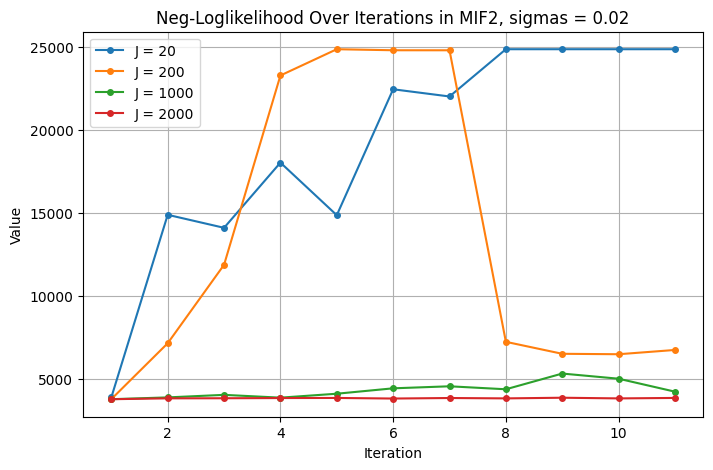

In [12]:
iterations = np.arange(1, 12) 

plt.figure(figsize=(8, 5))
plt.plot(iterations, mif_logliks_J2_true_1, marker='o', linestyle='-', markersize=4, label="J = 20")
plt.plot(iterations, mif_logliks_J3_true_1, marker='o', linestyle='-', markersize=4, label="J = 200")
plt.plot(iterations, mif_logliks_J4_true_1, marker='o', linestyle='-', markersize=4, label="J = 1000")
plt.plot(iterations, mif_logliks_J5_true_1, marker='o', linestyle='-', markersize=4, label="J = 2000")

plt.title("Neg-Loglikelihood Over Iterations in MIF2, sigmas = 0.02")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

plt.grid(True)
plt.show()

In [13]:
bbox = get_rand_theta(1).squeeze()
mif_logliks_J2_true_2, mif_params_J2_true_2 = _mif_internal(theta_dacca, ys=ys, sigmas=0.005, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J2, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J3_true_2, mif_params_J3_true_2 = _mif_internal(theta_dacca, ys, sigmas=0.005, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J3, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J4_true_2, mif_params_J4_true_2 = _mif_internal(theta_dacca, ys, sigmas=0.005, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J4, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J5_true_2, mif_params_J5_true_2 = _mif_internal(theta_dacca, ys, sigmas=0.005, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J5, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)

100%|██████████| 10/10 [10:17<00:00, 61.70s/it]


In [22]:
mif_logliks_J5_true_2

Array([3751.1272, 3754.444 , 3765.4678, 3763.803 , 3756.4146, 3758.4355,
       3775.9048, 3757.797 , 3756.6802, 3758.4087, 3768.6724],      dtype=float32)

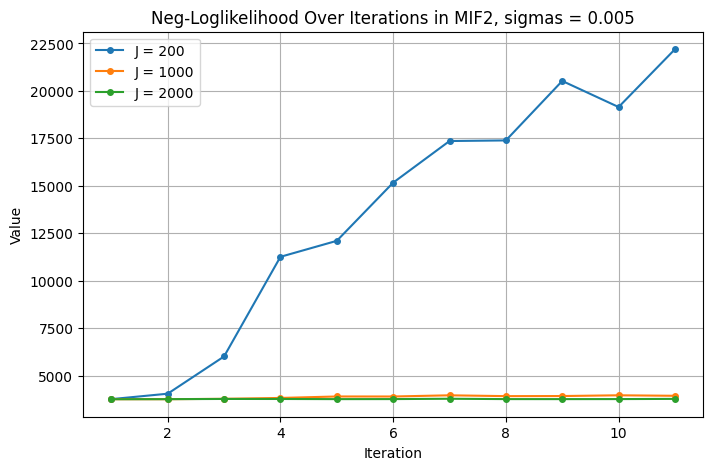

In [14]:
iterations = np.arange(1, 12) 

plt.figure(figsize=(8, 5))
#plt.plot(iterations, mif_logliks_J2_true, marker='o', linestyle='-', markersize=4, label="J = 20")
plt.plot(iterations, mif_logliks_J3_true_2, marker='o', linestyle='-', markersize=4, label="J = 200")
plt.plot(iterations, mif_logliks_J4_true_2, marker='o', linestyle='-', markersize=4, label="J = 1000")
plt.plot(iterations, mif_logliks_J5_true_2, marker='o', linestyle='-', markersize=4, label="J = 2000")

plt.title("Neg-Loglikelihood Over Iterations in MIF2, sigmas = 0.005")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

plt.grid(True)
plt.show()

In [15]:
bbox = get_rand_theta(1).squeeze()
mif_logliks_J2_true_3, mif_params_J2_tru_3 = _mif_internal(theta_dacca, ys=ys, sigmas=0.00005, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J2, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J3_true_3, mif_params_J3_true_3 = _mif_internal(theta_dacca, ys, sigmas=0.00005, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J3, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J4_true_3, mif_params_J4_true_3 = _mif_internal(theta_dacca, ys, sigmas=0.00005, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J4, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)
mif_logliks_J5_true_3, mif_params_J5_true_3 = _mif_internal(theta_dacca, ys, sigmas=0.00005, sigmas_init = 1e-20, covars=covars, verbose=False,M=10, J=J5, a=0.95, monitor=True, thresh=-1, rinit = rinit_dacca, rprocess = rprocess_dacca, dmeasure = dmeasure_dacca, rprocesses = rprocesses_dacca, dmeasures = dmeasures_dacca)

100%|██████████| 10/10 [09:25<00:00, 56.53s/it]


In [23]:
mif_logliks_J5_true_3

Array([3751.1272, 3746.5308, 3748.964 , 3749.3257, 3747.351 , 3747.3203,
       3749.6895, 3750.5173, 3748.6072, 3749.45  , 3749.6143],      dtype=float32)

In [24]:
mif_params_J5_true_3

Array([[[ 3.0349529, -2.8134108,       -inf, ..., -4.6918178,
         -8.477972 , -4.390059 ],
        [ 3.0349529, -2.8134108,       -inf, ..., -4.6918178,
         -8.477972 , -4.390059 ],
        [ 3.0349529, -2.8134108,       -inf, ..., -4.6918178,
         -8.477972 , -4.390059 ],
        ...,
        [ 3.0349529, -2.8134108,       -inf, ..., -4.6918178,
         -8.477972 , -4.390059 ],
        [ 3.0349529, -2.8134108,       -inf, ..., -4.6918178,
         -8.477972 , -4.390059 ],
        [ 3.0349529, -2.8134108,       -inf, ..., -4.6918178,
         -8.477972 , -4.390059 ]],

       [[ 3.0330765, -2.8117054,       -inf, ..., -4.6887197,
         -8.480078 , -4.389729 ],
        [ 3.0329585, -2.8116596,       -inf, ..., -4.688875 ,
         -8.48002  , -4.389764 ],
        [ 3.0329294, -2.8118489,       -inf, ..., -4.6887116,
         -8.480019 , -4.38957  ],
        ...,
        [ 3.034337 , -2.8131557,       -inf, ..., -4.6914763,
         -8.481841 , -4.3912516],
        [ 3.

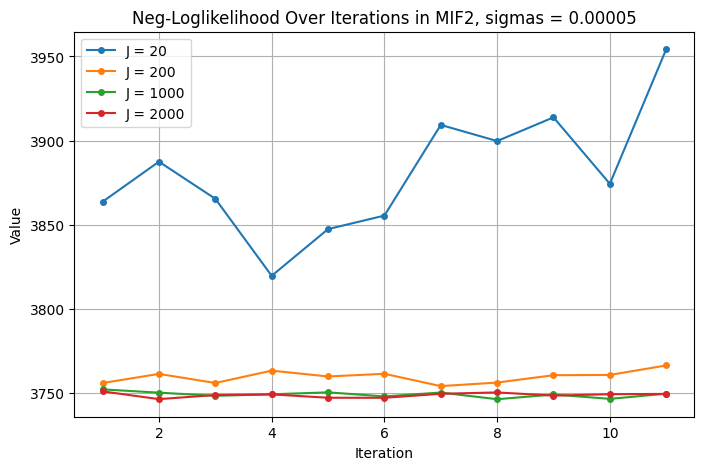

In [16]:
iterations = np.arange(1, 12) 

plt.figure(figsize=(8, 5))
plt.plot(iterations, mif_logliks_J2_true_3, marker='o', linestyle='-', markersize=4, label="J = 20")
plt.plot(iterations, mif_logliks_J3_true_3, marker='o', linestyle='-', markersize=4, label="J = 200")
plt.plot(iterations, mif_logliks_J4_true_3, marker='o', linestyle='-', markersize=4, label="J = 1000")
plt.plot(iterations, mif_logliks_J5_true_3, marker='o', linestyle='-', markersize=4, label="J = 2000")

plt.title("Neg-Loglikelihood Over Iterations in MIF2, sigmas = 0.00005")
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.legend()

plt.grid(True)
plt.show()

As the sigma decreases, the optimization process becomes more stable. When sigma is large, small J values exhibit significant fluctuations and spikes. Larger J values help reduce such instability, but the algorithm struggles to explore a lower negative log-likelihood further. When sigma is extremely small, the perturbations become minimal, where the parameter estimates remain very close to the true parameter value. Interestingly, for large J, the algorithm still finds a slightly lower negative log-likelihood than at the true parameter value. This may result from the approximation bias or numerical effects.